In [1]:
# import the necessary packages

import numpy as np

import cv2

import math

import time



In [2]:
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

classes = ['person']

with open ('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]
    
output_layers = net.getUnconnectedOutLayersNames()    
    

#### Select which camera to use for the live video you should use 0 or for additional camera use 1. If you want to use CCTV or IP Webcam put the URL under single codes

In [3]:
cap = cv2.VideoCapture('mall.mp4')

#cap = cv2.VideoCapture(0)  

In [4]:
# Euclidean Distance

def E_dist(p1, p2):
    #Euclidean distance between p1 and p2
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5  

#is_close method

def is_close(p1, p2):
    
    c_d = E_dist(p1, p2)
    
    calib = p1[1] + p2[1] /2
    
    if 0 < c_d < 0.15*calib:
        return 1            # p1 and p2 are close
    
    elif 0 < c_d < 0.2*calib :
        return 2            # p1 and p2 have medium distance
    
    else : 
        return 0            # # p1 and p2 are not close

In [5]:
height, width = (None,None)

q = 0

### We can't give the image directly to the algorithm. We first have to convert it into the blob.
### Blob extracts the features from the image. (416,416) is the standard size. 
### Then we pass the blob image to the algorithm.Then, finally, we feed the output layer to 'outs' for the final result.

In [6]:
while cap.isOpened() :
    
    ret,img = cap.read()
    
#     print(ret)
    
    if not ret:
        break
        
    if width is None or height is None :
        height, width  = img.shape[:2]
        q = width
        
    img =img[0:height, 0:q]

    height,width=img.shape[:2]
    
    blob = cv2.dnn.blobFromImage(img,0.00392, (416, 416), (0,0,0), True, crop=False)
    net.setInput(blob)
    
    start = time.time()
    outs = net.forward(output_layers)
    end = time.time()
    
    #Showing info in screen
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        
        for detection in out:
            
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            # threshold = 0.5
            if confidence > 0.5 :
                # Object detected
                # Purpose : Converts center coordinates to rectangle coordinates
                
                # x, y = midpoint of box
                center_x = int( detection[0] * width)
                center_y = int( detection[1] * height)
                
                # w, h = width, height of the box
                w = int( detection[2] * width)
                h = int( detection[3] * height)
                
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x,y,w,h])
                confidences.append( float(confidence))
                class_ids.append(class_id)
    
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)
    
    font = cv2.FONT_HERSHEY_SIMPLEX    

    if len(indexes>0):
        status = []
        idf = indexes.flatten()
        close_pair = []
        s_close_pair = []
        center = []
        dist = []
        
        for i in idf:
            (x,y) = (boxes[i][0],boxes[i][1])
            (w,h) = (boxes[i][2], boxes[i][3])
            center.append([ int(x + w / 2), int(y+h/2)])
            status.append(0)
            
        for i in range(len(center)):
            for j in range(len(center)):
                
                #compare the closeness of two values
                g = is_close(center[i], center[j])
                
                if g==1:
                    close_pair.append([center[i], center[j]])
                    status[i] = 1
                    status[j] = 1
                    
                elif g==2:
                    s_close_pair.append([center[i], center[j]])
                    if status[i] != 1:                        
                        status[i] = 2                        

                    if status[j] != 1:                        
                        status[j] = 2
                        
        total_p = len(center)        

        low_risk_p = status.count(2)        

        high_risk_p = status.count(1)        

        safe_p = status.count(0)        

        kk = 0        
        
        for i in idf:
            sub_img = img[10:170, 10:width - 10]    
            black_rect = np.zeros(sub_img.shape, dtype=np.uint8)
            res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 1.0)
            img[10:170, 10:width - 10] = res
            
            # adding text to image            
                      #(image,text,org( X coordinate value, Y coordinate value),font,fontScale,color,thikness)
            cv2.putText(img, "Social Distancing Detection - During Covid19", (255, 45),font, 1, (255, 255, 255), 2)
            
            #image = cv2.rectangle(image, start_point, end_point, color, thickness)

            cv2.rectangle(img, (20, 60), (625, 160), (170, 170, 170), 2)            

            cv2.putText(img, "Connecting lines shows closeness among people. ", (45, 80),font, 0.6, (255, 255, 0), 1)            

            cv2.putText(img, "YELLOW: CLOSE", (45, 110),font, 0.5, (0, 255, 255), 1)            

            cv2.putText(img, "RED: VERY CLOSE", (45, 130),font, 0.5, (0, 0, 255), 1)

            cv2.rectangle(img, (675, 60), (width -20, 160), (170, 170, 170), 2)            

            cv2.putText(img, "Bounding box shows the level of risk to the person.",(685, 80),font, 0.6, (255, 255, 0), 1)           

            cv2.putText(img, "DARK RED: HIGH RISK", (685, 110),font, 0.5, (0, 0, 150), 1)      

            cv2.putText(img, "ORANGE: LOW RISK", (685, 130),font, 0.5, (0, 120, 255), 1)

            cv2.putText(img, "GREEN: CONGRATULATIONS YOU ARE SAFE", (685, 150),font, 0.5, (0, 255, 0), 1)
            
            tot_str = "NUMBER OF PEOPLE: " + str(total_p)            

            high_str = "RED ZONE: " + str(high_risk_p)            

            low_str = "ORANGE ZONE: " + str(low_risk_p)            

            safe_str = "GREEN ZONE: " + str(safe_p)
            
            sub_img = img[height - 120:height-20, 0:500]
            
            #cv2.imshow("sub_img",sub_img)            

            black_rect = np.ones(sub_img.shape, dtype=np.uint8) * 0

            res = cv2.addWeighted(sub_img, 0.8, black_rect, 0.2, 1.0)

            img[height - 120:height-20, 0:500] = res

            cv2.putText(img, tot_str, (10, height - 75),font, 0.6, (255, 255, 255), 1)            

            cv2.putText(img, safe_str, (300, height - 75),font, 0.6, (0, 255, 0), 1)            

            cv2.putText(img, low_str, (10, height - 50),font, 0.6, (0, 120, 255), 1)            

            cv2.putText(img, high_str, (300, height - 50),font, 0.6, (0, 0, 150), 1)
            
            (x, y) = (boxes[i][0], boxes[i][1])            

            (w, h) = (boxes[i][2], boxes[i][3]) 
            
            
            #color of the ractangle when is too close 
            
            if status[kk] == 1:                
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 150), 2)
            elif status[kk] == 0:                
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            else:
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 120, 255), 2)
            kk += 1
            
        #Draw lines
        for h in close_pair:            
            cv2.line(img, tuple(h[0]), tuple(h[1]), (0, 0, 255), 2)         

        for b in s_close_pair:
            cv2.line(img, tuple(b[0]), tuple(b[1]), (0, 255, 255), 2)
                
    cv2.imshow('image',img)

    if cv2.waitKey(1) & 0xFF == ord('q'):

        break

    cv2.waitKey(1)

    #FourCC code is passed as

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        
    output = cv2.VideoWriter('output4.mp4',fourcc, 20.0, (img.shape[1], img.shape[0]))
                            
#     cv2.imwrite("output1.mp4",img)

    #img = cv2.flip(img,0)

    output.write(img)
    
cap.release()

output.release()

cv2.destroyAllWindows()

# press 'q' to release the window

## Output Screenshot
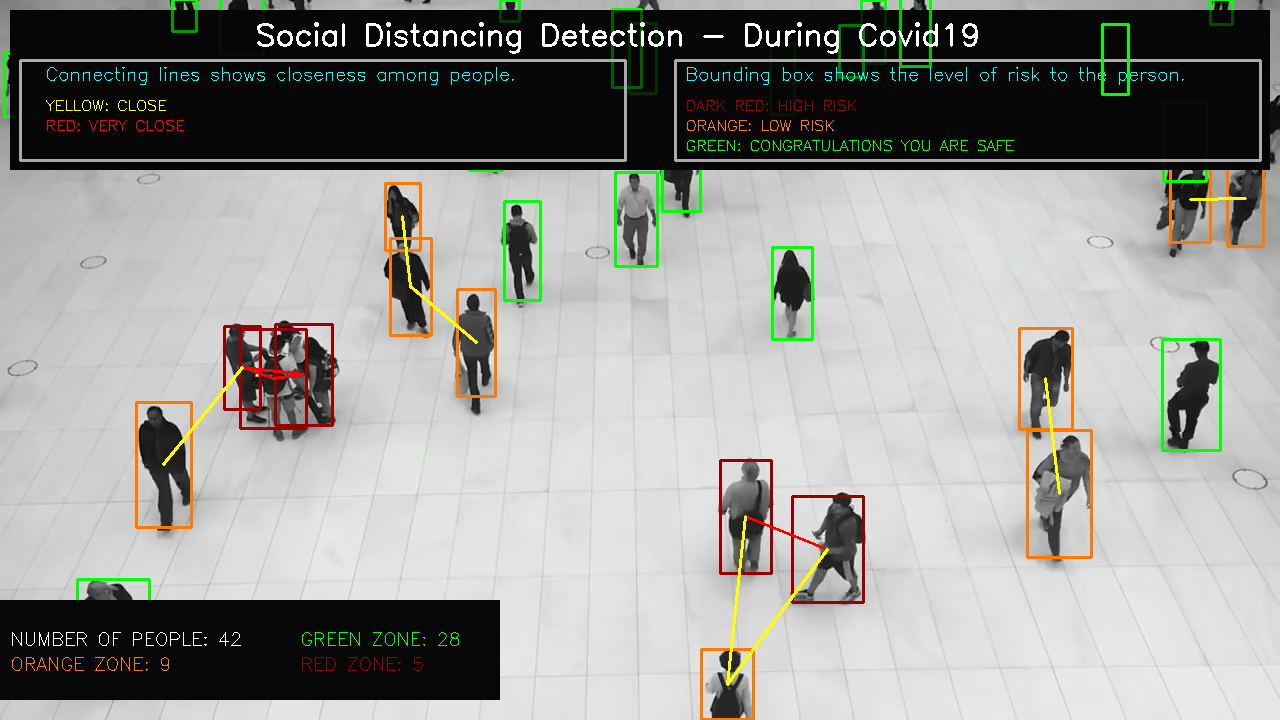